# Data Mining Versuch Verkehrsschilderkennung mit Neuronalen Netzen

* Autor: Prof. Dr. Johannes Maucher
* Datum: 01.06.2021

# Einführung

In diesem Versuch soll ein Convolutional Neural Network (CNN) für die Erkennung von Verkehrschildern implementiert, trainiert, evaluiert und getestet werden. Als Eingabe erhält das neuronale Netz Bilder von deutschen Verkehrsschildern. Ausgabe ist der Typ des Verkehrsschilds. Für Training und Test sind die Verkehrsschildbilder schon in separate Verzeichnissen abgelegt. Neben den Bildern selbst, enthält das zu diesem Versuch gehörende Datenverzeichnis auch Dateien mit Metadaten, die z.B. Bildeigenschaften, Verkehrsschildbedeutungen und die zugehörigen Klassenlabel beschreiben. Die Daten können Sie von hier herunterladen: https://cloud.mi.hdm-stuttgart.de/s/eQbA7wQttqqKLHW

## Lernziele:
In diesem Versuch sollen Kenntnisse in folgenden Themen vermittelt werden:

* Convolutional Neural Networks (CNNs)
* Implementierung Tiefer Neuronaler Netze mit Tensorflow und Keras: 
    - Definition der Netzarchitektur
    - Training
    - Evaluation und Test
    
* Einfache Methoden der Bildverarbeitung:
    - Augmentierung
    - Kontrastverstärkung

* Evaluation eines Klassifikators


## Vorbereitung

### Grundlagen Neuronale Netze
Machen Sie sich mit den [Grundlagen herkömmlicher Neuronaler Netze (KI Vorlesung)](https://gitlab.mi.hdm-stuttgart.de/maucher/KI/blob/master/Slides/09_PartLernen4.pdf) und den [Grundlagen Convolutional Neural Networks ((KI Vorlesung))](https://gitlab.mi.hdm-stuttgart.de/maucher/KI/blob/master/Slides/V11DeepLearningKIversion.pdf) vertraut.


### Implementierung Neuronaler Netze mit Tensorflow und Keras
Machen Sie sich mit der Implementierung von Neuronalen Netzen mit Tensorflow und Keras vertraut. Z.B. mit den [Tensorflow Quickstart Tutorials](https://www.tensorflow.org/tutorials/quickstart/beginner)

# Durchführung

## Vorbereitende Untersuchungen
1. Importieren Sie ein Bild aus dem Verzeichnis `Train` mit der [scikit-image.io](https://scikit-image.org/docs/dev/api/skimage.io.html)-Methode `imread()` und zeigen Sie dieses mit der Methode `imshow()` an. Geben Sie die Größe des Bildes aus (Attribut `.shape`). 
2. Verändern Sie die Größe des Bildes mit der [scikit-image.transform](https://scikit-image.org/docs/dev/api/skimage.transform.html)-Methode `resize()` auf eine Größe von $32x32x3$. Die Verzerrung des Seitenverhältnisses kann dabei ignoriert werden. Diese Methode führt auch eine Normalisierung der Pixelwerte von [0,255] auf [0,1] durch.
3. Führen Sie mit der [scikit-image.exposure](https://scikit-image.org/docs/dev/api/skimage.exposure.html)-Methode `equalize_adapthist()` eine Kontrastverstärkung des Bildes durch. Zeigen Sie das vergrößerte und kontrastangereicherte Bild an. **Anmerkung:** Das kontrastverstärkte Bild sieht zwar unschöner aus, auf der Basis kontrastverstärkter Bilder läßt sich aber im allgemeinen die Objekterkennung verbessern.
2. Importieren Sie die Datei `Train.csv` und machen Sie sich mit deren Inhalt vertraut. Die Datei `Test.csv` ist gleich strukturiert, bezieht sich aber auf die Bilder im Verzeichnis `Test`. Wieviele Zeilen enthalten die Dateien?
3. Importieren Sie die Datei `signnames.csv` und machen Sie sich mit deren Inhalt vertraut. 

In [4]:
import skimage.io as io
import numpy as np
from skimage.transform import resize
from skimage import exposure
import pandas as pd
import plotly.graph_objects as go
from sklearn.preprocessing import OneHotEncoder
io.use_plugin('matplotlib')
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,Activation,BatchNormalization,Dropout,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

(30, 29, 3)
Shape:  (30, 29, 3)


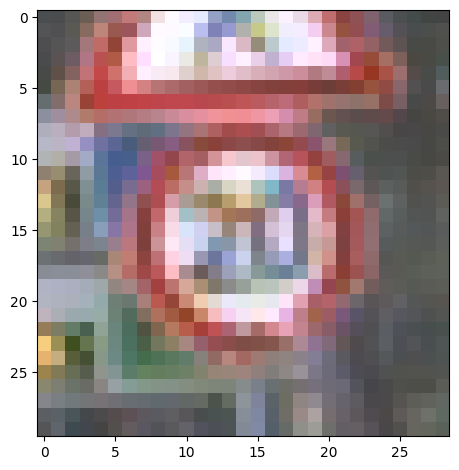

In [5]:
#1
picture = "./traffic-sign-recognition/data/Train/0/00000_00000_00000.png"
read_picture = io.imread(picture)
print(read_picture.shape)
io.imshow(read_picture)
print("Shape: ",read_picture.shape)

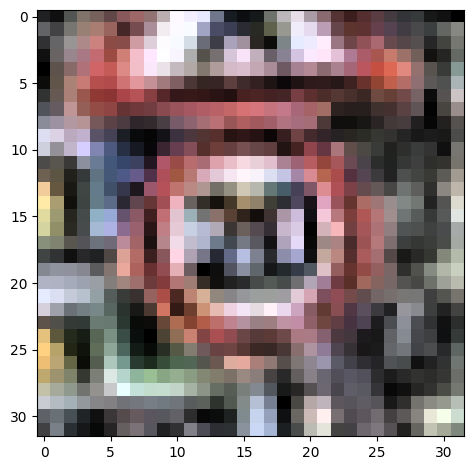

In [6]:
#2
resized_picture = resize(read_picture, (32, 32, 3))

#3
high_contrast_picture = exposure.equalize_adapthist(resized_picture)
io.imshow(high_contrast_picture)

In [7]:
images = [resized_picture, resized_picture, resized_picture, resized_picture, resized_picture]
np.array(images).shape

(5, 32, 32, 3)

<h3 style="color: gold"> Erklaerung</h3>

Train: 39209 Zeilen   
Test: 12630 Zeilen

Bilder sind nicht teil der CSV, da diese zu groß sind. Die CSV beinhaltet nur die Metadaten zu den Bildern.

In [8]:
#Methode welche die Anzahl der Zeilen und Spalten von csv Daten zurückgibt
def getRowsAndColumns(csv_data):
        dict = {"Zeilen" : [csv_data.shape[0]],
                "Spalten" : [csv_data.shape[1]]}

        df_rows_and_columns = pd.DataFrame(dict, index=["Anzahl"])
        return df_rows_and_columns

In [11]:
#4
train_df = pd.read_csv('./traffic-sign-recognition/data/Train.csv')
display(train_df.head())
display(getRowsAndColumns(train_df))

test_df = pd.read_csv('./traffic-sign-recognition/data/test.csv')
display(test_df.head())
display(getRowsAndColumns(test_df))

#5
signnames_df = pd.read_csv('./traffic-sign-recognition/data/signnames.csv')
print(signnames_df.head())


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


,Zeilen,Spalten
Anzahl,39209,8


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


,Zeilen,Spalten
Anzahl,12630,8


   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)


## Funktion für den Import aller Trainings- bzw. Testbilder
Schreiben Sie eine Funktion mit folgenden Eigenschaften:
* Der Funktion wird der Name der Datei übergeben, in welcher die Metadaten stehen, also entweder `Train.csv` oder `Test.csv`.
* Rückgabewerte der Funktion sind 
    * ein 4-dimensionales numpy-array, das alle Bilder des jeweiligen Verzeichnisses (Training oder Test) enthält.
    * ein 1-dimensionales numpy-array, das die Klassenlabel aller Bilder enthält.
* Die Bilder müssen alle auf eine Größe von $32x32x3$ skaliert werden (wie in der Vorbereitungsaufgabe).
* Für alle Bilder ist eine Kontrastverstärkung durchzuführen (wie in der Vorbereitungsaufgabe).

**Tipps für die Implementierung dieser Funktion:**

Iterieren Sie mit einer for-Schleife über alle Zeilen des metadaten-Files. Pro Iteration kann dann 
* der vollständige Verzeichnis- und Filenamen ausgelesen werden,
* das entsprechende Bild mit `imread()` eingelesen werden,
* das Bild auf die vorgegebene Größe angepasst werden,
* der Kontrast des Bildes verstärkt werden.

**Wichtig:** In den von der Funktion zurückgegebenen Arrays, dürfen die Bilder nicht wie in der ursprünglichen Reihenfolge im Dateiverzeichnis enthalten sein. Um sicherzustellen, dass beim Training jedes Minibatch möglichst viele verschiedene Klassen enthält, muss die Reihenfolge geshuffelt werden. Am einfachsten ist es, wenn gleich die Zeilen des Metadatenfiles geshuffelt werden.

<h3 style="color: gold"> Erklaerung</h3>
Professional representation of the 4 dimenstions: 

  1. Dimension: Number of images   
  2. Dimension: Height of the image
  3. Dimension: Width of the image
  4. Dimension: Number of channels (RGB)

![](https://media.discordapp.net/attachments/938091917877608488/1054348153022857236/image.png)


In [12]:
def prepare_data(csv_filename):
    df = pd.read_csv(csv_filename)
    df = df.sample(frac=1).reset_index(drop=True) # Shuffle
    display(df.head(4)) # Shuffled
    image_list = []
    classlabel_list = []
    for i in range(len(df)):
        full_path = './traffic-sign-recognition/data/' + df['Path'][i]
        image = io.imread(full_path)#
        resized_image = resize(image, (32, 32, 3))
        high_contrast_image = exposure.equalize_adapthist(resized_image)
        image_list.append(high_contrast_image)
        classlabel_list.append(df['ClassId'][i])
    return image_list, classlabel_list

## Laden und Vorverarbeiten der Trainings- und Testdaten
1. Laden Sie mit der in der vorigen Teilaufgabe implementierten Funktion alle Trainingsbilder (`trainX`), Trainingslabel (`trainY`), Testbilder (`testX`) und Testlabel (`testY`)
1. Bestimmen Sie die Häufigkeitsverteilung der Klassen in den Trainings- und Testdaten. Visualisieren Sie diese.
3. Alle Labels, sowohl der Trainings- als auch der Testdaten müssen One-Hot-encodiert werden.

<h3 style="color: gold"> Erklaerung</h3>

Die Verteilung der Klassen in Train und Test sind nahezu identisch.    
Generell ist zum Trainieren eines Neuronalen Netzes eine Verteilung der Klassen, die möglichst gleichmäßig ist, von Vorteil.
Es koennte spaeter zu einem Problem werden, dass z.B. Klassen 0, 19, 27, 32 sehr wenig vorkommen, wenn dann Schilder zweier Klassen aehnlich aussehen, z.B. 80kmh und 60kmh, dann kann es dazu kommen, dass das Netzwerk die Klassen 80 und 60 nicht richtig unterscheiden kann, da 60kmh zu wenig Trainingsdaten hat.

In [14]:
trainX, trainY = prepare_data('./traffic-sign-recognition/data/Train.csv')

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,55,56,5,6,50,51,8,Train/8/00008_00013_00019.png
1,53,49,5,6,48,44,18,Train/18/00018_00027_00017.png
2,58,60,5,5,53,54,18,Train/18/00018_00022_00002.png
3,48,48,6,5,43,43,9,Train/9/00009_00011_00016.png


In [15]:
testX, testY = prepare_data('./traffic-sign-recognition/data/Test.csv')

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,46,46,5,5,41,41,4,Test/00973.png
1,50,48,5,5,45,43,24,Test/03521.png
2,32,34,5,6,26,28,32,Test/03938.png
3,28,29,6,6,23,24,12,Test/06754.png


In [16]:
print(np.array(trainX).shape)
print(np.array(trainY).shape)

(39209, 32, 32, 3)
(39209,)


In [30]:
#2
test_Y_counts = {key: testY.count(key) for key in np.unique(testY)}
train_Y_counts = {key: trainY.count(key) for key in np.unique(trainY)}

fig = go.Figure(data=[go.Bar(name="Test",x=list(test_Y_counts.keys()), y=[value/sum(test_Y_counts.values()) for value in test_Y_counts.values()])])
fig.add_trace(go.Bar(name="Train",x=list(train_Y_counts.keys()), y=[value/sum(train_Y_counts.values()) for value in train_Y_counts.values()]))
fig.update_layout(title="Test and Train Labels")
fig.update_layout(xaxis_title="ClassId", yaxis_title="Percentage",width=1000, height=500)
fig.show()

In [33]:
#3
trainY = np.array(trainY)
print(trainY)
encoder = OneHotEncoder()
trainYHot = encoder.fit_transform(np.array(trainY).reshape(-1, 1)).toarray()
testYHot = encoder.fit_transform(np.array(testY).reshape(-1, 1)).toarray()
print(trainYHot.shape)
print(testYHot[0].shape)

print(trainYHot[0])
print(testYHot[0])

[ 8 18 18 ...  2 27 39]
(39209, 43)
(43,)
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Definition der CNN Architektur
Schreiben Sie eine Funktion `generateCNN(width, height, depth, classes)` die eine Keras CNN-Architektur zurück gibt. Für die Definition der Architektur werden dieser Funktion die Parameter:

* `width`: Breite der Bilder
* `height`: Höhe der Bilder
* `depth`: Anzahl der Kanäle pro Bild
* `classes`: Anzahl der unterschiedlichen Klassen

übergeben. Die in der Funktion zu implementierende Architektur ist im folgenden Bild dargestellt. In der Spalte *Output shape* bezeichnen die zweite und dritte Zahl die Breite und die Höhe der einzelnen Kanäle (*Bilder*), der letzte Parameter bezeichnet die Anzahl der Kanäle (Parameter *filters* in der Konfiguration).
In der Übersichtstabelle ist die Filtergröße nicht aufgeführt. Empfohlen sind folgende Größen:
* für alle Pooling Layer: *pool_size=(2,2)*.
* für den ersten Conv2D-Layer: *kernel_size=(5,5)*.
* für alle weiteren Conv2D-Layer: *kernel_size=(3,3)*

**Anmerkung:** Der in der Tabelle mit *flatten_5* bezeichnete Layer ist nicht notwendig und erzeugt in bestimmten Keras-Versionen eine Fehlermeldung. Der Layer sollte nicht in die Architektur mit aufgenommen werden.


<img src="https://maucher.home.hdm-stuttgart.de/Pics/cnnTrafficSign.png" style="width:700px" align="middle">

<h3 style="color: gold"> Erklaerung</h3>

Wir haben nicht erwartet, dass man bei so einem Model, wirklich alle Schritte hintereinander aufschreiben muss. Es sieht durchaus nach einem riesen Klotz von Code aus.

In [61]:
#1


def generateCNN(classes,width=32,height=32,depth=3):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    model.add(Conv2D(8, (5, 5), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128)) # 65664
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128)) # 16512
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    return model

def generateCNNSoftOnly(classes,width=32,height=32,depth=3):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    model.add(Conv2D(8, (5, 5), padding="same",input_shape=inputShape))
    model.add(Activation("softmax"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(Activation("softmax"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(Activation("softmax"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("softmax"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("softmax"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128)) # 65664
    model.add(Activation("softmax"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128)) # 16512
    model.add(Activation("softmax"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    return model


## Training des CNN
Rufen Sie die im vorigen Abschnitt implementierte Funktion `generateCNN()` auf und weisen Sie die von der Funktion zurückgegebene Architektur der Variablen `model` zu. Durch Aufruf der Funktion `model.summary()` erhalten Sie eine Übersicht des erzeugten Netzes.

Für das Training soll der `Adam`-Algorithmus aus dem Modul `tensorflow.keras.optimizers` benutzt werden. `Adam` implementiert ein *Stochastic Gradient Descent*-Lernverfahren, welches die Lernraten für die Gewichte individuell und dynamisch anpasst.

In den folgenden zwei Codezellen, werden die Trainingsparameter konfiguriert:

In [62]:
model = generateCNN(trainYHot.shape[1])
model2 = generateCNNSoftOnly(trainYHot.shape[1])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 32, 32, 8)         608       
                                                                 
 activation_33 (Activation)  (None, 32, 32, 8)         0         
                                                                 
 batch_normalization_24 (Bat  (None, 32, 32, 8)        32        
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 16)        1168      
                                                                 
 activation_34 (Activation)  (None, 16, 16, 16)       

In [36]:
NUM_EPOCHS = 15 # Number of training epochs 
INIT_LR = 1e-3 # Initial Learning Rate for ADAM training
BS = 64 # Size of minibatches

In [63]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5)) 
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
model2.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

Für das Training sollen nicht nur die vorhandenen Trainingsbilder eingesetzt werden, sondern zusätzlich Bilder die Augmentierungen der Trainingsbilder sind. Augmentierte Bilder können mit dem `ImageDataGenerator` des Moduls `tensorflow.keras.preprocessing.image` erzeugt werden. Der Code für die Erzeugung des in diesem Projekt eingesetzten Objekts ist unten gegeben. 

**Aufgabe:** Erklären Sie was in dieser Codezelle definiert wird.

<h3 style='color: gold'>Erklärung<h3>

**TODO**

In [51]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

Das Training wird mit folgender Codezelle ausgeführt.

**Aufgabe:** Erklären Sie die Argumente der Funktion `fit_generator()`. 

Für die Ausführung der Zelle muss das Dictionary `classWeight` angelegt sein. Dieses enthält für jede Klasse den Klassenindex als key und den relativen Anteil dieser Klasse in den Trainingsbildern als Value. Wenn z.B. 30% aller Trainingsdaten zur Klasse 0 gehören, dann wäre der Value zum Key 0 der Wert 0.3.

<h3 style='color: gold'>Erklärung<h3>

**TODO**

In [52]:
# classWeight dictionary
total = sum(train_Y_counts.values())
print(total)
classWeight = {key: value/total for key, value in train_Y_counts.items()}
print(classWeight)

39209
{0: 0.005355913183197735, 1: 0.05661965365094749, 2: 0.05738478410569002, 3: 0.03596113137289908, 4: 0.05049861001300722, 5: 0.04743808819403708, 6: 0.01071182636639547, 7: 0.03672626182764161, 8: 0.03596113137289908, 9: 0.03749139228238415, 10: 0.05126374046774975, 11: 0.03366574000867148, 12: 0.05355913183197735, 13: 0.05508939274146242, 14: 0.019893391823305875, 15: 0.016067739549593205, 16: 0.01071182636639547, 17: 0.028309826825473745, 18: 0.030605218189701345, 19: 0.005355913183197735, 20: 0.009181565456910403, 21: 0.00841643500216787, 22: 0.009946695911652937, 23: 0.01300721773062307, 24: 0.0068861740926828025, 25: 0.03825652273712668, 26: 0.015302609094850672, 27: 0.006121043637940269, 28: 0.013772348185365605, 29: 0.0068861740926828025, 30: 0.011476956821138005, 31: 0.019893391823305875, 32: 0.006121043637940269, 33: 0.017572496110586856, 34: 0.01071182636639547, 35: 0.030605218189701345, 36: 0.009946695911652937, 37: 0.005355913183197735, 38: 0.05279400137723482, 39: 0.

In [53]:
#DEBUGGING
#print(np.array(trainX)[0])
print(np.array(trainX).shape) # List of images
print(np.array(trainYHot)) # List of class labels
print(np.array(trainYHot).shape)
print(np.array(trainX)[0].shape)

(39209, 32, 32, 3)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(39209, 43)
(32, 32, 3)


<h3 style='color: gold'>Erklärung</h3>

* **generator:** Erzeugt Batches von Trainingsdaten. In diesem Fall gibt die Funktion `aug.flow` einen Generator zurück, der Batches von augmentierten Daten liefert. Der Generator muss ein Tupel (inputs, targets) liefern, wobei inputs eine Liste von Eingabedaten und targets eine Liste von entsprechenden Zieldaten ist.
* **validation_data:**  Ein Tupel (x_val, y_val) zur Verwendung als Validierungsdaten. Das Modell wird nicht auf diesen Daten trainiert, aber sie werden verwendet, um die Leistung des Modells während des Trainings zu bewerten.
* **steps_per_epoch:** Die Anzahl der Batches, die der generator ausgeben muss, bevor er eine Epoche für beendet erklärt und die nächste Epoche beginnt. Dies wird verwendet, um sicherzustellen, dass der Generator für eine feste Anzahl von Schritten pro Epoche ausgeführt wird, anstatt unendlich lange zu laufen.
* **epochs:** Die Anzahl der Epochen, für die das Modell trainiert wird. Eine Epoche ist ein einzelner Durchlauf durch den gesamten Datensatz.
* **class_weight:** Ein Dictionary, das Klassenindizes auf einen Gewichtswert abbildet, der zur Gewichtung der Verlustfunktion während des Trainings verwendet wird. Auf diese Weise kann bestimmten Klassen im Datensatz mehr Bedeutung beigemessen werden.
* **verbose:** Ein Integer, das den Fortschritt der durchlaufenden Epochen in Form einer Progressbar anzeigt. Ein Wert von 0 bedeutet, dass keine Ausgabe erfolgt, während ein Wert von 1 einen Fortschrittsbalken und Epochenzahlen ausgibt.

In [54]:
print("[INFO] training network...")
H2= model2.fit_generator(
    aug.flow(np.array(trainX), trainYHot, batch_size=BS),
    validation_data=(np.array(testX), testYHot),
    steps_per_epoch=np.array(trainX).shape[0] // BS,
    epochs=NUM_EPOCHS,
    class_weight=classWeight,
    verbose=1)
print("Done")

[INFO] training network...
Epoch 1/15


C:\Users\Maximus Lachsimus\AppData\Local\Temp\ipykernel_20792\3951274824.py:2: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



612/612 [==============================] - 32s 50ms/step - loss: 0.0603 - accuracy: 0.3905 - val_loss: 2.2431 - val_accuracy: 0.4629
Epoch 2/15
612/612 [==============================] - 32s 53ms/step - loss: 0.0229 - accuracy: 0.6678 - val_loss: 0.8898 - val_accuracy: 0.7433
Epoch 3/15
612/612 [==============================] - 29s 47ms/step - loss: 0.0151 - accuracy: 0.7476 - val_loss: 0.5925 - val_accuracy: 0.8108
Epoch 4/15
612/612 [==============================] - 29s 47ms/step - loss: 0.0119 - accuracy: 0.7872 - val_loss: 0.5796 - val_accuracy: 0.8253
Epoch 5/15
612/612 [==============================] - 29s 48ms/step - loss: 0.0102 - accuracy: 0.8123 - val_loss: 0.6915 - val_accuracy: 0.8059
Epoch 6/15
612/612 [==============================] - 30s 49ms/step - loss: 0.0089 - accuracy: 0.8294 - val_loss: 0.4338 - val_accuracy: 0.8605
Epoch 7/15
612/612 [==============================] - 31s 50ms/step - loss: 0.0078 - accuracy: 0.8448 - val_loss: 0.4314 - val_accuracy: 0.8654
Epo

In [64]:
# compile the model and train the network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(np.array(trainX), trainYHot, batch_size=BS),
    validation_data=(np.array(testX), testYHot),
    steps_per_epoch=np.array(trainX).shape[0] // BS,
    epochs=NUM_EPOCHS,
    class_weight=classWeight,
    verbose=1)
print("Done")

[INFO] training network...
Epoch 1/15


C:\Users\Maximus Lachsimus\AppData\Local\Temp\ipykernel_20792\1724571619.py:3: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



612/612 [==============================] - 29s 45ms/step - loss: 0.0804 - accuracy: 0.3134 - val_loss: 1.5549 - val_accuracy: 0.5466
Epoch 2/15
612/612 [==============================] - 26s 43ms/step - loss: 0.0372 - accuracy: 0.5535 - val_loss: 0.9584 - val_accuracy: 0.6984
Epoch 3/15
612/612 [==============================] - 27s 44ms/step - loss: 0.0238 - accuracy: 0.6690 - val_loss: 0.7249 - val_accuracy: 0.7549
Epoch 4/15
612/612 [==============================] - 27s 43ms/step - loss: 0.0177 - accuracy: 0.7314 - val_loss: 0.6613 - val_accuracy: 0.7859
Epoch 5/15
612/612 [==============================] - 26s 42ms/step - loss: 0.0141 - accuracy: 0.7707 - val_loss: 0.5850 - val_accuracy: 0.8156
Epoch 6/15
612/612 [==============================] - 26s 43ms/step - loss: 0.0120 - accuracy: 0.8002 - val_loss: 0.4589 - val_accuracy: 0.8527
Epoch 7/15
612/612 [==============================] - 26s 43ms/step - loss: 0.0104 - accuracy: 0.8213 - val_loss: 0.3929 - val_accuracy: 0.8736
Epo

Visualisieren Sie die Entwicklung der *Accuracy* über dem Fortschritt der Trainingsepochen. Plotten Sie dabei die entsprechenden Kurven der Accuracy auf den Trainings- und auf den Testdaten in einen Graphen.

Weil Theodoridis das mal sehen wollte:   

ChatGPT Frage:
```yml
H = model.fit_generator(
    aug.flow(np.array(trainX), trainYHot, batch_size=BS),
    validation_data=(np.array(testX), testYHot),
    steps_per_epoch=np.array(trainX).shape[0] // BS,
    epochs=NUM_EPOCHS,
    class_weight=classWeight,
    verbose=1)

Visualize the Accuracy over the epochs
```

Der Code der Antwort 1 zu 1 pasted:

<h3 style='color: gold'>Erklärung</h3>

Wir haben gelesen, dass man bei hidden layers die Activation `relu` benutzen soll, da diese negative werte auf 0 setzt. Das soll die Rechenleistung erhöhen.
Bei den `Dense` Schritten werden die Klassen gebildet, und da soll `softmax` besser sein.

Aus Interesse haben wir auch ein Model trainiert bei dem wir nur softmax benutzen und mussten feststellen, dass der Unterschied nicht wirklich gross ist..
Die Accuracies waren: `Softmax Only:  0.91  Softmax + Relu:  0.93`

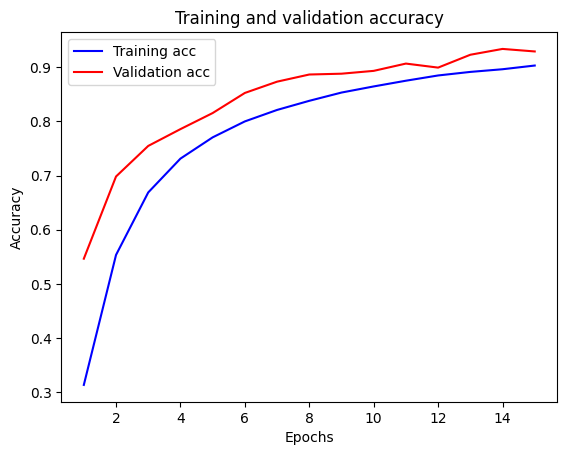

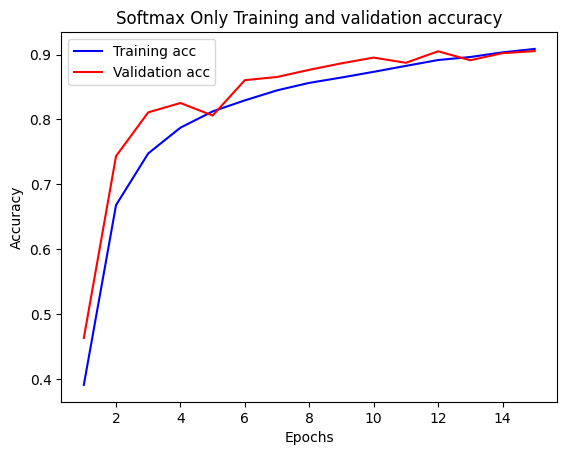

Accuracies: Softmax Only:  0.9053048491477966  Softmax + Relu:  0.9293745160102844


In [65]:
import matplotlib.pyplot as plt

# Get the training and validation accuracy values
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']

# Get the number of epochs
epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy values
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# MODEL 2

acc2 = H2.history['accuracy']
val_acc2 = H2.history['val_accuracy']

epochs2 = range(1, len(acc2) + 1)

plt.plot(epochs2, acc2, 'b', label='Training acc')
plt.plot(epochs2, val_acc2, 'r', label='Validation acc')
plt.title('Softmax Only Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

print("Accuracies: Softmax Only: ", val_acc2[-1], " Softmax + Relu: ", val_acc[-1])


## Evaluation des gelernten Modells

Wenden Sie das gelernte CNN an, um für alle Bilder des Testdatensatzes die Art des Verkehrsschildes zu bestimmen. Evaluieren Sie die Qualität des CNN indem Sie einen `classification_report()` aus dem Modul `sklearn.metrics` erzeugen. 

1. Welche Metriken werden im Report angezeigt? Beschreiben Sie diese kurz?
2. Diskutieren Sie die Klassifikationsgenauigkeit des CNN anhand des Reports.

Zeigen Sie 5 Bilder an, die nicht korrekt klassifiziert wurden. Läßt sich die Fehlklassifikation erklären?

<h3 style="color: gold">Erklaerung</h3>

Von den Dargestellten Falschen Bildern (5,19,24,27,32) sind 5 und 24 auch fuer uns nicht zu erkennen.

Die anderen 3 Haetten wir richtig Klassifiziert, dennoch ist das Problem bei 32 mit den Zahlen 6 und 8 klar, dass je verpixelter die Zahlen sind, desto schwerer ist die "Oeffnung" der 6 zu erkennen. Beispiel kennt man aus dem Sehtest.

19 verstehen wir nicht, da die 2 doch sehr gut von einer 3 Unterscheidbar ist.
27 Ist sehr grenzwertig verpixelt, Wir koennen es aber noch erkennen, was vermutlich an der Faehigkeit des Menschen liegt, sich den "Rest" eines bildes auszumahlen, somit koennen wir die Reifen erdenken, waehrend das model das nicht kann.



 
Metriken: 

1. Precision<br>
Ist die genauigkeit der Vorhersage, ob die Klassen wenn sie vorhergesagt werden, auch richtig sind.
Leider scheint es 2 Ausreisser zu geben, Klassen 19 und 27 haben eine Precision von 0.00, was bedeutet, dass das Model diese niemals positiv vorhersagt. Dies ist ein Problem, da die Klassen 19 und 27 auch nicht sehr oft vorkommen, wie oben als Vorahnung bereits erwaehnt.

1. Recall<br>


2. F1-Score<br>
Der F-Score setzt sich aus Precision und Recall (harmonisches Mittel) zusammen und beschreibt die Gesamtgenauigkeit der Vorhersagen. Ein guter F-Score ist perfekt wenn es den Wert 1 besitzt, während 0 sehr schlecht ist.
Wie bei Precision und Recall schon erwaehnt, ist das bei Klassen 19 und 27 der Fall. Was sehr schlecht fuer das Model ist. Und bedeutet wir werden diese 2 Schilder wahrscheinlich niemals richtig vorhersagen.

1. Accuracy<br>
Accuracy beschreibt die Genauigkeit bzw. Rate aller insgesamt richtigen Klassifikationen. Da dieser Wert hier um die 88% beträgt kann wieder geschlussfolgert werden, dass recht gut klassifiziert wurde.
Zumindest bis auf bei 19 und 27 (haha PAIN)

<br>
(Aus Notizen von der Vorlesung "Künstliche Intelligenz")

**TODO**
Report sachen Diskutieren


In [87]:
from sklearn.metrics import classification_report
images = testX
labels = testY # [1,21,2,41,14,5,15, ...]
wanted = 5
wrong_count = 0

predictions = model.predict(np.array(images))
predicted_labels = np.argmax(predictions, axis=1)

report = classification_report(labels,predicted_labels)
print(report)

395/395 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

           0       0.88      0.63      0.74        60
           1       0.98      0.99      0.99       720
           2       0.95      0.99      0.97       750
           3       0.95      0.93      0.94       450
           4       0.99      0.96      0.97       660
           5       0.93      0.94      0.93       630
           6       0.84      0.87      0.85       150
           7       0.89      0.96      0.93       450
           8       0.92      0.95      0.94       450
           9       0.95      0.98      0.96       480
          10       1.00      0.99      0.99       660
          11       0.91      0.93      0.92       420
          12       0.99      0.98      0.98       690
          13       0.99      1.00      1.00       720
          14       0.97      1.00      0.99       270
          15       0.93      0.85      0.89       210
          16       1.00   

In [92]:
signnames_csv = pd.read_csv('traffic-sign-recognition/data/signnames.csv')
#labels =  list(signnames_csv['SignName'])

classificationReport = classification_report(testY.astype(int), predicted_labels, target_names=testY.astype(int))

AttributeError: 'list' object has no attribute 'astype'

In [80]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(labels, predicted_labels)
plt.show()


C:\Users\Maximus Lachsimus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



TypeError: plot_confusion_matrix() missing 1 required positional argument: 'y_true'

ValueError: Found input variables with inconsistent numbers of samples: [43, 12630]

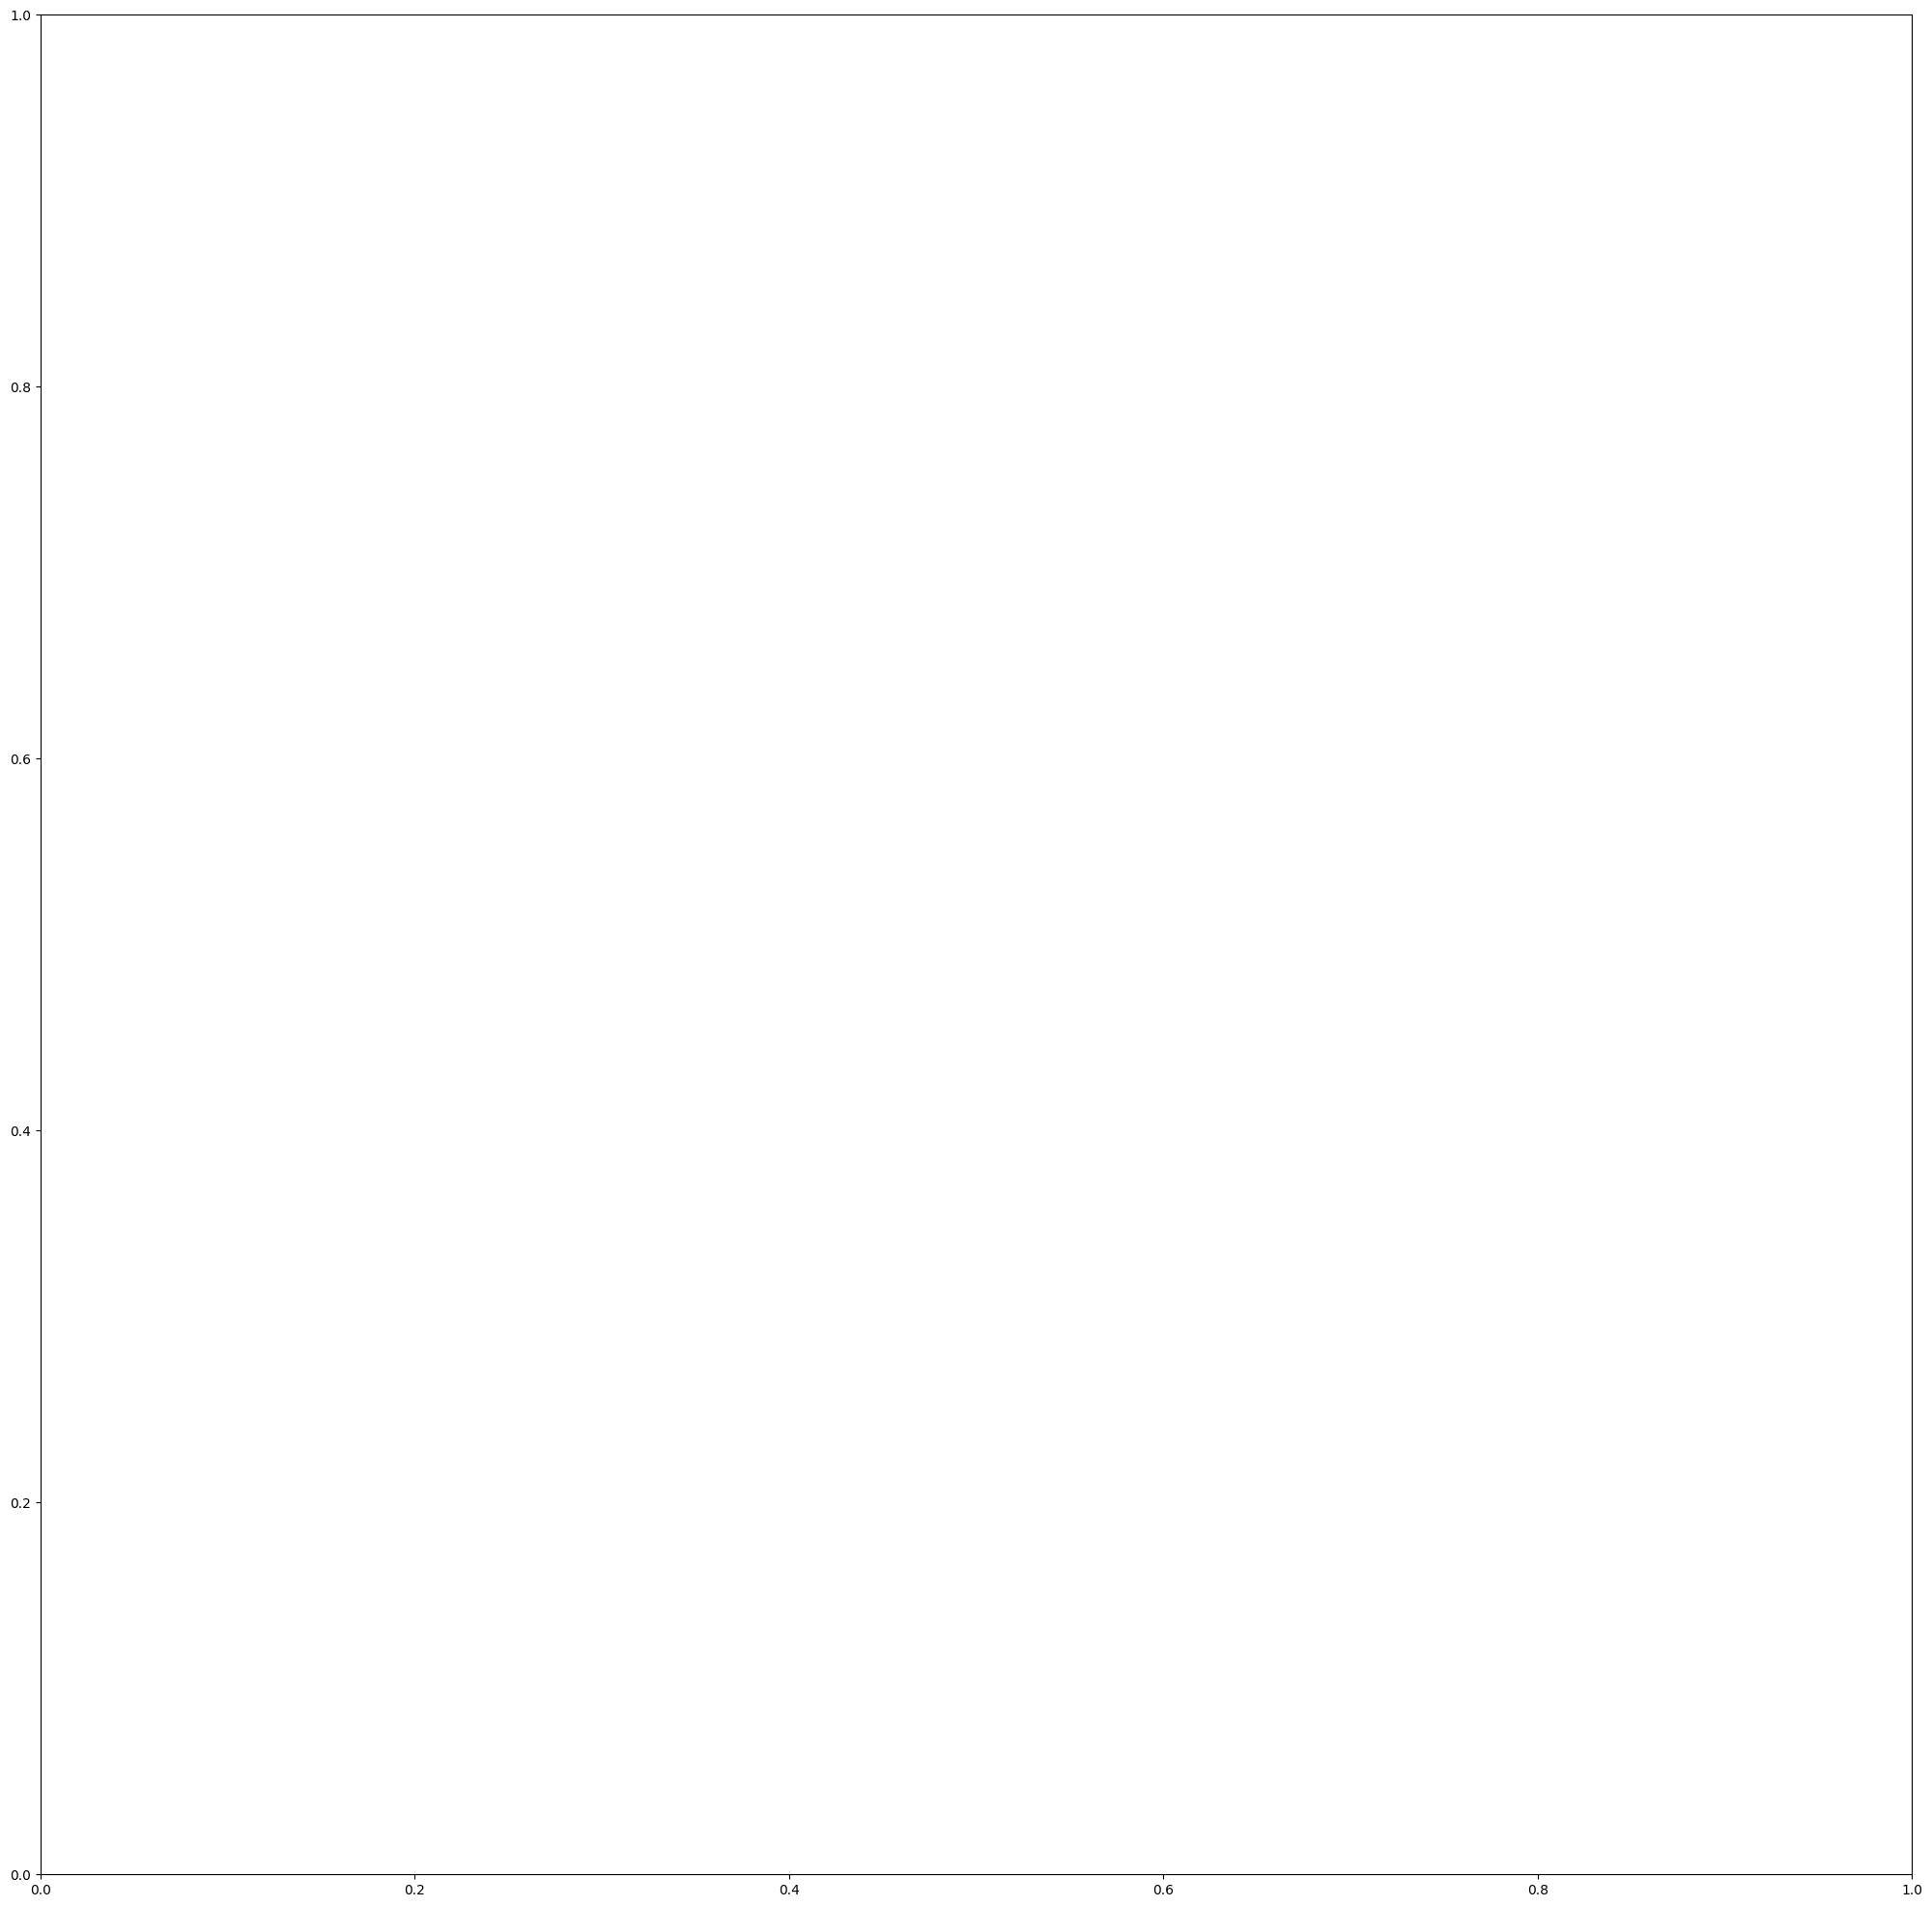

In [79]:
from sklearn.metrics import plot_confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt

signnames_csv = pd.read_csv('traffic-sign-recognition/data/signnames.csv')
labels =  list(signnames_csv['SignName'])

skplt.metrics.plot_confusion_matrix(
    labels, 
    predicted_labels,
    figsize=(25, 25),
    title="Confusion matrix")
plt.show()

Image: 1 Prediction | Actual: General caution | Road narrows on the right


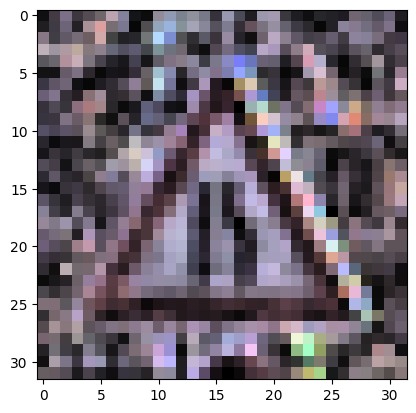

Image: 6 Prediction | Actual: End of speed limit (80km/h) | Beware of ice/snow


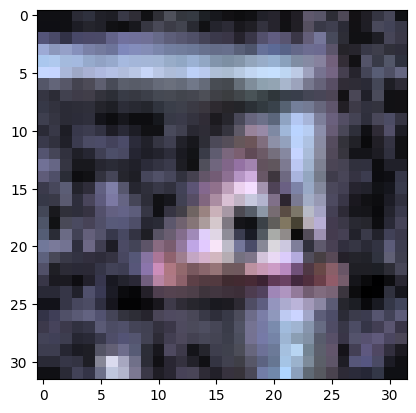

Image: 8 Prediction | Actual: Right-of-way at the next intersection | General caution


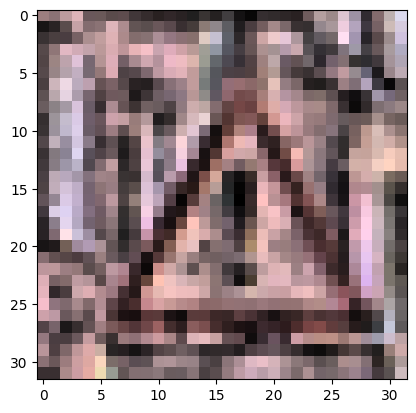

Image: 15 Prediction | Actual: Traffic signals | Pedestrians


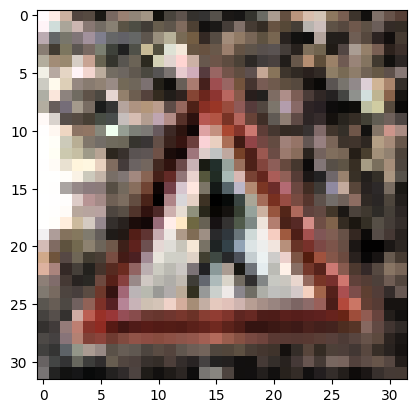

Image: 24 Prediction | Actual: Right-of-way at the next intersection | Beware of ice/snow


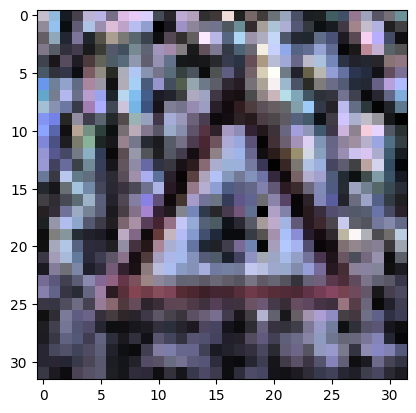

Wrong predictions:  1558  out of  12630
Accuracy:  0.8766429136975455


In [58]:


for i in range(len(images)):
  predicted_label = np.argmax(predictions[i])
  actual_label = labels[i]
  if predicted_label != actual_label:
    wrong_count += 1
    if wanted > 0:
      wanted -= 1
      print("Image: {} Prediction | Actual: {} | {}".format(i,  signnames_df.loc[predicted_label].SignName,  signnames_df.loc[actual_label].SignName))
      plt.imshow(images[i])
      plt.show()

print("Wrong predictions: ", wrong_count, " out of ", len(images))
print("Accuracy: ", (len(images) - wrong_count) / len(images))